In [ ]:
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 

In [2]:
import numpy as np
import pandas as pd

# import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt

# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")

In [3]:
%cd ./
# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('./')

c:\Users\khais\Documents\GitHub\final_year_project\BERT_Training


c:\Users\khais\Documents\GitHub\final_year_project\BERT_Training\env\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# Load Dataset
true_data = pd.read_csv("a1_True.csv")
fake_data = pd.read_csv("a2_Fake.csv")

# Create labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data["Target"] = ["True"] * len(true_data)
fake_data["Target"] = ["Fake"] * len(fake_data)

# Make a dictionary for label mapping
label_map = {"Fake": 1, "True": 0}

# Apply the label mapping to the 'Target' column in both DataFrames
true_data["label"] = true_data["Target"].replace(label_map)
fake_data["label"] = fake_data["Target"].replace(label_map)

# Combine true_data and fake_data, by random mixing into a single df called data
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)


# print(data.shape)
# data.head()

## Train-test-split

In [5]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(
    data["title"],
    data["label"],
    random_state=2018,
    test_size=0.3,
    stratify=data["Target"],
)
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels
)

## BERT Fine-tuning
### Load pretrained BERT Model

In [6]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

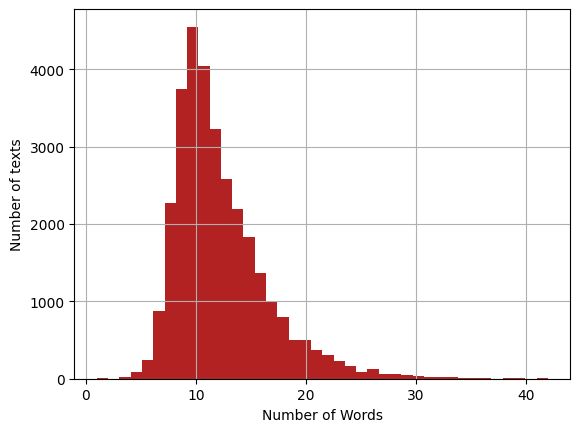

In [7]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins=40, color="firebrick")
plt.xlabel("Number of Words")
plt.ylabel("Number of texts")

In [8]:
# BERT Tokenizer Functionality
sample_data = ["Build fake news model.", "Using bert."]  # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(
    sample_data, padding=True
)  # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [9]:
# title length usually under 15th words, can set more if needed.
MAX_LENGHT = 15

# Tokenize and encode sequences in the train set

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(), max_length=MAX_LENGHT, pad_to_max_length=True, truncation=True
)

# tokenize and encode sequences in the validation set

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(), max_length=MAX_LENGHT, pad_to_max_length=True, truncation=True
)

# tokenize and encode sequences in the test set

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(), max_length=MAX_LENGHT, pad_to_max_length=True, truncation=True
)

c:\Users\khais\Documents\GitHub\final_year_project\BERT_Training\env\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_labels.tolist())

In [11]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32  # define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)  # wrap tensors
train_sampler = RandomSampler(
    train_data
)  # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)  # wrap tensors
val_sampler = SequentialSampler(
    val_data
)  # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# dataLoader for validation set

### Freeze Layers


In [12]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False  # false here means gradient need not be computed

### Define Model Architecture

In [13]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)  # dropout layer
        self.relu = nn.ReLU()  # relu activation function
        self.fc1 = nn.Linear(768, 512)  # dense layer 1
        self.fc2 = nn.Linear(512, 2)  # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)  # softmax activation function

    def forward(self, sent_id, mask):  # define the forward pass
        cls_hs = self.bert(sent_id, attention_mask=mask)["pooler_output"]
        # pass the inputs to the model
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # output layer
        x = self.softmax(x)  # apply softmax activation
        return x


model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)  # learning rate
# Define the loss function
cross_entropy = nn.NLLLoss()
# Number of training epochs
epochs = 2

c:\Users\khais\Documents\GitHub\final_year_project\BERT_Training\env\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Defining training and evaluation functions
def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_dataloader):  # iterate over batches
        if step % 50 == 0 and not step == 0:  # progress update after every 50 batches.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))
        batch = [r for r in batch]  # push the batch to gpu
        sent_id, mask, labels = batch
        model.zero_grad()  # clear previously calculated gradients
        preds = model(sent_id, mask)  # get model predictions for current batch
        loss = cross_entropy(
            preds, labels
        )  # compute loss between actual & predicted values
        # loss = torch.nn.functional.nll_loss(preds, labels)           # compute loss using nll_loss (assuming it expects raw logits)
        total_loss = total_loss + loss.item()  # add on to the total loss
        loss.backward()  # backward pass to calculate the gradients
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), 1.0
        )  # clip gradients to 1.0. It helps in preventing exploding gradient problem
        optimizer.step()  # update parameters
        preds = (
            preds.detach().cpu().numpy()
        )  # model predictions are stored on GPU. So, push it to CPU

    avg_loss = total_loss / len(train_dataloader)  # compute training loss of the epoch
    # reshape predictions in form of (# samples, # classes)
    return avg_loss  # returns the loss and predictions


def evaluate():
    print("\nEvaluating...")
    model.eval()  # Deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    for step, batch in enumerate(val_dataloader):  # Iterate over batches
        if step % 50 == 0 and not step == 0:  # Progress update every 50 batches.
            # Calculate elapsed time in minutes.
            # Elapsed = format_time(time.time() - t0)
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(val_dataloader)))
            # Report progress
        batch = [t for t in batch]  # Push the batch to GPU
        sent_id, mask, labels = batch
        with torch.no_grad():  # Deactivate autograd
            preds = model(sent_id, mask)  # Model predictions
            loss = cross_entropy(
                preds, labels
            )  # Compute the validation loss between actual and predicted values
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
    avg_loss = total_loss / len(
        val_dataloader
    )  # compute the validation loss of the epoch
    return avg_loss

### Model training

In [15]:
# Train and predict
best_valid_loss = float("inf")
train_losses = []  # empty lists to store training and validation loss of each epoch
valid_losses = []

for epoch in range(epochs):
    print("\n Epoch {:} / {:}".format(epoch + 1, epochs))
    train_loss = train()  # train model
    valid_loss = evaluate()  # evaluate model
    if valid_loss < best_valid_loss:  # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "model_weights.pt")
    train_losses.append(train_loss)  # append training and validation loss
    valid_losses.append(valid_loss)

    print(f"\nTraining Loss: {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.563
Validation Loss: 0.484

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

### Model performance

In [16]:
# load weights of best model
path = "model_weights.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [17]:
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3212
           1       0.90      0.80      0.85      3523

    accuracy                           0.85      6735
   macro avg       0.85      0.85      0.85      6735
weighted avg       0.85      0.85      0.85      6735



## Fake News Predictions

In [18]:
# # load weights of best model
# model.load_state_dict(torch.load(path))

In [19]:
# testing on unseen data
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",  # Fake
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",  # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",  # True
    "Trump administration issues new rules on U.S. visa waivers",  # True
]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text, max_length=MAX_LENGHT, pad_to_max_length=True, truncation=True
)

unseen_seq = torch.tensor(tokens_unseen["input_ids"])
unseen_mask = torch.tensor(tokens_unseen["attention_mask"])

with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
preds

c:\Users\khais\Documents\GitHub\final_year_project\BERT_Training\env\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([1, 0, 0, 0], dtype=int64)

In [20]:
# Save / export tokenizer for use in rust backend.
tokenizer.save_pretrained("./tokenizer")
"""







dummy_input = torch.randint(0, 1000, (1, 512), dtype=torch.long).to(
    "cpu"







)  # Use CPU and LongTensor







torch.onnx.export(







    model,







    (dummy_input, dummy_input),







    "fake_news_detection_model.onnx",







    input_names=["input_ids", "attention_mask"],







    output_names=["output"],
)






"""
# Export model to onnx format for use in rust backend.


dummy_input = torch.randint(0, 1000, (1, 128), dtype=torch.long).to(
    "cpu"
)  # Use CPU and LongTensor


torch.onnx.export(
    model,
    (dummy_input, dummy_input),
    "fake_news_detection_model.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["output"],
    opset_version=15,
)